In [ ]:
# Mount google drive to access the dataset, which is saved on google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1.0 load libraries and preprocess data as pandas dataframe.

In [ ]:
!pip install arviz
!pip install --upgrade cmdstanpy[all]

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 184kB 7.6MB/s 
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.76 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


from datetime import datetime

# fix random seed
np.random.seed(1234)

In [ ]:
# download the latest data (4/9/21) from the cdc website - https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf

# To use outside of colab, replace filename with the download path of the cdc data on your own device.
filename = 'gdrive/My Drive/Colab Notebooks/AMS 561 Final Project/COVID-19_Case_Surveillance_Public_Use_Data.csv'

In [ ]:
data = pd.read_csv(filename)

FileNotFoundError: ignored

In [ ]:
len(data)

In [ ]:
data.columns

## 1.1 seperate data based on ethnicities

In [ ]:
# 4/27/21 - Get data for ethnicities
list_of_race_ethnicities = data['race_ethnicity_combined'].drop_duplicates().tolist()
list_of_race_ethnicities

In [ ]:
# unknown is a large part of the pie.
data.groupby('race_ethnicity_combined').size().plot(kind='pie', figsize=(10,10))

In [ ]:
#do groupby to form a multi-level hierarchical index.
race_demo_hosp_df = data.groupby(['cdc_case_earliest_dt ', 'race_ethnicity_combined', 'age_group', 'hosp_yn']).size()

# drop the multi-level hierarchical index.
race_demo_hosp_df = race_demo_hosp_df.reset_index()

# set age_group as new index.
#race_demo_hosp_df.set_index('age_group')

# rename the 0 column to "counts"
race_demo_hosp_df = race_demo_hosp_df.rename(columns={0:'positive_covid_case_count'})

# convert datetime to datetime object
race_demo_hosp_df.loc[:,'cdc_case_earliest_dt '] = [datetime.strptime(date, '%Y/%m/%d') for date in race_demo_hosp_df['cdc_case_earliest_dt ']]

In [ ]:
race_demo_hosp_df_col_list = race_demo_hosp_df.columns.tolist()
race_demo_hosp_df_col_list

In [ ]:
race_ethnicity_list = race_demo_hosp_df['race_ethnicity_combined'].unique().tolist()
race_ethnicity_list

In [ ]:
# this is a hierarchical dataframe
race_demo_hosp_multi_df = race_demo_hosp_df.groupby(['cdc_case_earliest_dt ', 'race_ethnicity_combined']).size()

# unstack hierarchical dataframe to utilize for plotting.
race_demo_hosp_multi_df = race_demo_hosp_multi_df.unstack(level=0)

# race_demo_hosp_multi_df = race_demo_hosp_multi_df.reset_index() #just trying to see if reset index works, temporary code for now.
race_demo_hosp_multi_df = race_demo_hosp_multi_df.fillna(0)
race_demo_hosp_multi_df

In [ ]:
del race_ethnicity_list[-2:] #remove 'American Indian/Alaska Native, Non-Hispanic','Native Hawaiian/Other Pacific Islander, Non-Hispanic' ethnic groups

In [ ]:
race_ethnicity_list

In [ ]:
ethnicity_list_largest = ['Asian, Non-Hispanic',
 'Black, Non-Hispanic',
 'Hispanic/Latino',
 'White, Non-Hispanic']

In [ ]:
for ethnicity in ethnicity_list_largest:
  race_demo_hosp_multi_df.loc[ethnicity][90:].pct_change().plot(kind='line', label=ethnicity, figsize=(20, 10)) # chop off the first  90 days of recorded data
  # race_demo_hosp_multi_df.loc[ethnicity].pct_change().plot(kind='line', label=ethnicity, figsize=(20, 10))
plt.title("cumulative case count per ethnicity")
plt.legend()

In [ ]:
ethnicity_data_list = []
for ethnicity in ethnicity_list_largest:
  ethnicity_data_list.append(race_demo_hosp_multi_df.loc[ethnicity].pct_change().fillna(0).tolist())

In [ ]:
print(len(ethnicity_data_list))

## 1.2 seperate data based on age

In [ ]:
grouby_age_df = data.groupby(['age_group', 'cdc_case_earliest_dt ']).size().reset_index(name='counts') #don't really need to reset the index here. I am leaving it in place because it might break the code later though.

# 4/25/21 turned off, column doesn't appear useful later on.
# TUTORIAL 4/19/21 - https://stackoverflow.com/questions/53645882/pandas-merging-101
#merged_df = grouby_age_df.merge(groupby_daily_cases_df,on='cdc_case_earliest_dt ',how='left',suffixes=('','_total_daily'))

merged_df = grouby_age_df
merged_df

In [ ]:
# merge age groups into 3 main groups. Note that the rows are not even
young_df = merged_df[(merged_df['age_group'] == '0 - 9 Years') | (merged_df['age_group'] == '10 - 19 Years') | (merged_df['age_group'] == '20 - 29 Years')]
mid_df = merged_df[(merged_df['age_group'] == '30 - 39 Years') | (merged_df['age_group'] == '40 - 49 Years') | (merged_df['age_group'] == '50 - 59 Years')]
old_df = merged_df[(merged_df['age_group'] == '60 - 69 Years') | (merged_df['age_group'] == '70 - 79 Years') | (merged_df['age_group'] == '80+ Years')]

# drop age_group column because it isn't needed anymore.
#young_df = young_df.drop(columns=['age_group'])
#mid_df = mid_df.drop(columns=['age_group'])
#old_df = old_df.drop(columns=['age_group'])

In [ ]:
# convert 'cdc_case_earliest_dt ' column values from string to datetime object.
young_df.loc[:,'cdc_case_earliest_dt '] = [datetime.strptime(date, '%Y/%m/%d') for date in young_df['cdc_case_earliest_dt ']]
mid_df.loc[:,'cdc_case_earliest_dt '] = [datetime.strptime(date, '%Y/%m/%d') for date in mid_df['cdc_case_earliest_dt ']]
old_df.loc[:,'cdc_case_earliest_dt '] = [datetime.strptime(date, '%Y/%m/%d') for date in old_df['cdc_case_earliest_dt ']]

In [ ]:
# 4/25/21 - this groups all of the dates and the counts per date of the age group. However it makes all of the columns except "counts" useless. Refactored code to not use the "useless" columns
young_df = young_df.reset_index().groupby('cdc_case_earliest_dt ').sum()
mid_df = mid_df.reset_index().groupby('cdc_case_earliest_dt ').sum()
old_df = old_df.reset_index().groupby('cdc_case_earliest_dt ').sum()

In [ ]:
# add cumulative count column
young_df['cum count'] = young_df['counts'].cumsum()
mid_df['cum count'] = mid_df['counts'].cumsum()
old_df['cum count'] = old_df['counts'].cumsum()

In [ ]:
# drop columns we don't need
young_df = young_df.drop(columns=['index'])
mid_df = mid_df.drop(columns=['index'])
old_df = old_df.drop(columns=['index'])

In [ ]:
young_df

In [ ]:
# plot daily cases per each age group.
ax = plt.figure(figsize=(25, 12)).gca()

young_df.plot(kind='line',y='counts', color='r', ax=ax, label="0 - 29 Years")
mid_df.plot(kind='line',y='counts', color='b', ax=ax, label='30 - 59 Years')
old_df.plot(kind='line',y='counts', color='g', ax=ax, label='60 - 80+ Years')

plt.xlabel('date')
plt.ylabel('daily case per age group')
plt.title("Daily cases per age group")
plt.legend(loc="upper right");

plt.show();

In [ ]:
# information hand copied from https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/

# each age is in millions
# 0 - 29
young_age_group = (10.01 + 9.57) + (10.32 + 9.87) + (10.62 + 10.18) + (10.75 + 10.31) + (11.06 + 10.57) + (12 + 11.5)
young_age_group = young_age_group * 1e6

# 30 - 59
mid_age_group = (11.35 + 11.08) + (10.88 + 10.85) + (9.91 + 10.01) + (10.09 + 10.31) + (10.09 + 10.39) + (10.65 + 11.23)
mid_age_group = mid_age_group * 1e6

# 60-80+
old_age_group = (9.86 + 10.71) + (8.2 + 9.26) + (6.5 + 7.53) + (4.32 + 5.33) + (2.68 + 3.64) + (2.38 + 4.23)
old_age_group = old_age_group * 1e6

In [ ]:
print("percent of people ages 0 - 29 that have covid are: ", young_df['counts'].sum() / young_age_group)
print("percent of people ages 30 - 59 that have covid are: ", mid_df['counts'].sum() / mid_age_group)
print("percent of people ages 60 - 80+ that have covid are: ", old_df['counts'].sum() / old_age_group)

# 2.0 prepare Stan age model

In [ ]:
# get data to use for stan model from previous part
stan_model_data = pd.DataFrame()
stan_model_data['young_daily_covid'] = young_df['counts']
stan_model_data['mid_daily_covid'] = mid_df['counts']
stan_model_data['old_daily_covid'] = old_df['counts']

# add a total daily case count column
stan_model_data['total_daily_cases'] = stan_model_data.sum(axis=1)

# add columns to reflect daily age case counts as a percent of total daily cases.
stan_model_data['young_daily_covid_percent'] = stan_model_data['young_daily_covid'] / stan_model_data['total_daily_cases']
stan_model_data['mid_daily_covid_percent'] = stan_model_data['mid_daily_covid'] / stan_model_data['total_daily_cases']
stan_model_data['old_daily_covid_percent'] = stan_model_data['old_daily_covid'] / stan_model_data['total_daily_cases']

In [ ]:
stan_model_data

,young_daily_covid,mid_daily_covid,old_daily_covid,total_daily_cases,young_daily_covid_percent,mid_daily_covid_percent,old_daily_covid_percent
cdc_case_earliest_dt,,,,,,,
2020-01-01,70,124,67,261,0.268199,0.475096,0.256705
2020-01-02,67,111,39,217,0.308756,0.511521,0.179724
2020-01-03,57,75,42,174,0.327586,0.431034,0.241379
2020-01-04,126,148,71,345,0.365217,0.428986,0.205797
2020-01-05,90,93,51,234,0.384615,0.397436,0.217949
...,...,...,...,...,...,...,...
2021-03-12,14862,17082,5878,37822,0.392946,0.451642,0.155412
2021-03-13,12703,14580,4718,32001,0.396956,0.455611,0.147433
2021-03-14,10548,11988,3818,26354,0.400243,0.454884,0.144874


In [ ]:
# Add covid deaths dataframe
# 4/28/21 - ADDING THIS TO SECTION 2.0, SHOULD PROBABLY REMOVE THIS FROM SECTION 2.3

# 4/27/21 - added new line for "death_df"
groupby_daily_cases_df = data.groupby(['death_yn', 'cdc_case_earliest_dt ']).size().reset_index(name='counts')

# 4/27/21 - This is new data to use!
death_df = groupby_daily_cases_df[(groupby_daily_cases_df['death_yn'] == 'Yes')]

# this is the number of deaths
death_df['cum count'] = death_df['counts'].cumsum()
death_df['death cum count percent change'] = death_df['cum count'].pct_change() # 4/27/21 Note around a 2% daily death rate mean.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
# add hospitalization rates dataframe 
# 4/27/21 - added new line for "hosp_yn"
groupby_hosp_df = data.groupby(['hosp_yn', 'cdc_case_earliest_dt ']).size().reset_index(name='counts')

# 4/27/21 - This is new data to use!
hosp_df = groupby_hosp_df[(groupby_hosp_df['hosp_yn'] == 'Yes')]

# this is the number of deaths
hosp_df['cum count'] = hosp_df['counts'].cumsum()
hosp_df['hosp_yn cum count percent change'] = hosp_df['cum count'].pct_change() # 4/27/21 Note around a 2% daily death rate mean.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


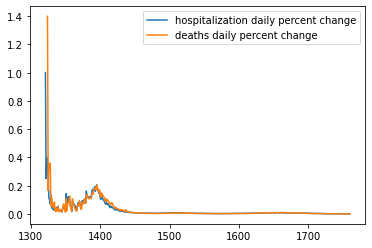

In [ ]:
# plot some arbitrary stuff with the new hospitalization and death dataframes.
hosp_df['hosp_yn cum count percent change'].plot(label="hospitalization daily percent change")
death_df['death cum count percent change'].plot(label="deaths daily percent change")

plt.legend()
plt.show()

In [ ]:
# prepare data to put into dictionary. Data needs to be in dictionary format to use in Stan
index_count = len(stan_model_data.index)

x_vals = [x for x in range(0,index_count)]
y1 = stan_model_data['young_daily_covid_percent'].tolist()
y2 = stan_model_data['mid_daily_covid_percent'].tolist()
y3 = stan_model_data['old_daily_covid_percent'].tolist()
y4 = hosp_df['hosp_yn cum count percent change'].fillna(0).tolist()

# sigma =stan_model_data['young_daily_covid_percent'].std()**2

keys = ['N', 'y1', 'y2', 'y3', 'y4']
cdc_data_dict = dict(zip(keys,[index_count, y1, y2, y3, y4]))
cdc_data_dict.keys()

dict_keys(['N', 'y1', 'y2', 'y3', 'y4'])

In [ ]:
stan_model_data['young_daily_covid_percent'].mean()

0.3096189131770908

In [ ]:
# 4/11/21 - resources/docmuntation guides
# - https://github.com/stan-dev/example-models/blob/master/jupyter/covid-inf-rate/SantaClara_CmdStanPy.ipynb
# - https://cmdstanpy.readthedocs.io/en/stable-0.9.65/getting_started.html
# - stan reference manual - https://mc-stan.org/docs/2_26/reference-manual/hmc-chapter.html

In [ ]:
import cmdstanpy
# downloads CmdStan from GitHub and builds the CmdStan utilities.
cmdstanpy.install_cmdstan() #need cmdstan for cmdstanpy to run on, note this step takes a while to finish.

Installing CmdStan version: 2.26.1
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpp__gbw1v
Unpacked download as cmdstan-2.26.1
Building version cmdstan-2.26.1
Test model compilation
Installed cmdstan-2.26.1
deleting tmpfiles dir: /tmp/tmpu5z8o60b
done



True

## 2.1 calculate posterior distribution for age model

In [ ]:
#create basic STAN model with age and hospitalization rates

age_model = """
data { 
  int<lower=0> N; // number of variables 
  vector[N] y1; // estimated percentage of young cases
  vector[N] y2; // estimated percentage of mid cases
  vector[N] y3; // estimated percentage of old cases
  vector[N] y4; // estimated percentage of old cases
} 

parameters {
  real<lower=0, upper=1> theta1;
  real<lower=0, upper=1> theta2;
  real<lower=0, upper=1> theta3;
  real<lower=0, upper=1> hospital_theta;
} 

model {
  theta1 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y1 ~ normal(theta1, 1);

  theta2 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y2 ~ normal(theta2, 1);

  theta3 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y3 ~ normal(theta3, 1);

  hospital_theta ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y4 ~ normal(hospital_theta, 1);

}
"""

with open("age_model.stan", "w") as f:
    f.write(age_model)

sm = cmdstanpy.CmdStanModel(stan_file="age_model.stan")
samples = sm.sample(data=cdc_data_dict, output_dir="./")

INFO:cmdstanpy:compiling stan program, exe file: /content/age_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/age_model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [ ]:
# this only shows 2 decimals for the mean, I want it to show more...
samples.summary().round(decimals=4)
# lp__ is "total joint log probability density"
# R_hat column is the degree of convergence of a random Markov Chain can be estimated using the Gelman-Rubin convergence statistic

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-14.00,0.0480,1.600,-17.0000,-14.000,-12.00,1100.0,5900.0,1.0
theta1,0.31,0.0008,0.048,0.2300,0.310,0.39,3600.0,19000.0,1.0
theta2,0.46,0.0008,0.048,0.3800,0.460,0.54,3600.0,18000.0,1.0
theta3,0.23,0.0009,0.047,0.1500,0.230,0.30,2600.0,14000.0,1.0
hospital_theta,0.05,0.0006,0.034,0.0049,0.045,0.11,3100.0,16000.0,1.0


In [ ]:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2020b/content/lessons/setup.html#Installing-Stan-with-CmdStanPy


In [ ]:
# 4/24/21 STOP - https://opendatagroup.github.io/data%20science/2019/01/24/introduction-to-bayesian-modeling.html
# build more complex models with linear regression and more variables?

In [ ]:
inf_data = az.convert_to_inference_data(samples) #samples is the "fit" data

In [ ]:
#inference data object from arviz. Makes looking at models very straight forward!
inf_data

Inference data with groups:
	> posterior
	> sample_stats

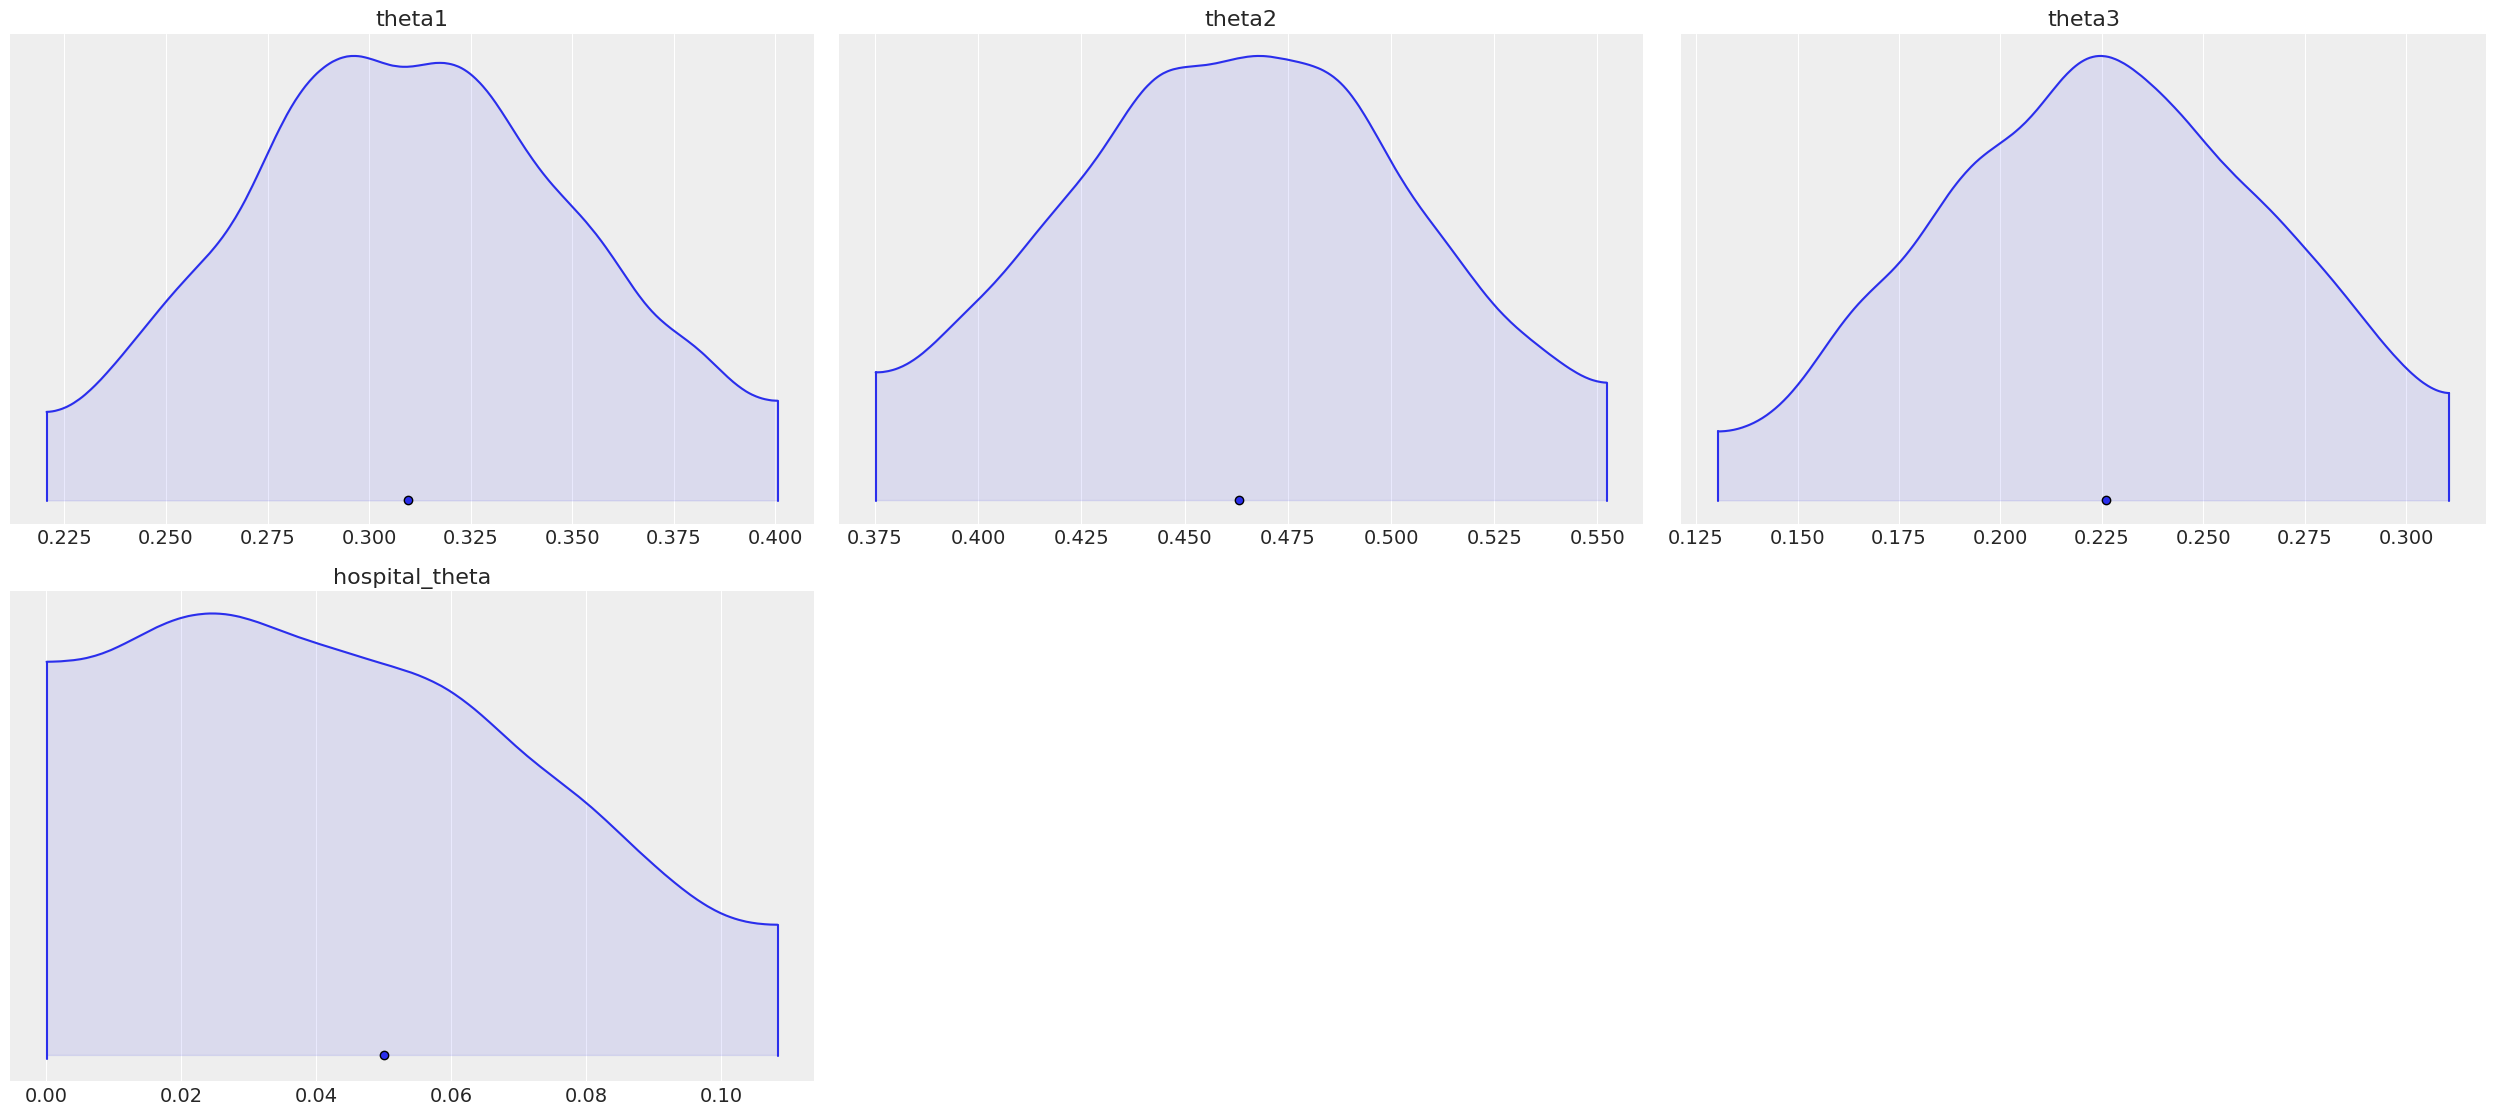

In [ ]:
az.style.use("arviz-darkgrid")


az.plot_density(
    [inf_data],
    var_names=["theta1", "theta2", "theta3", "hospital_theta"],
    shade=0.1,
)
plt.show()

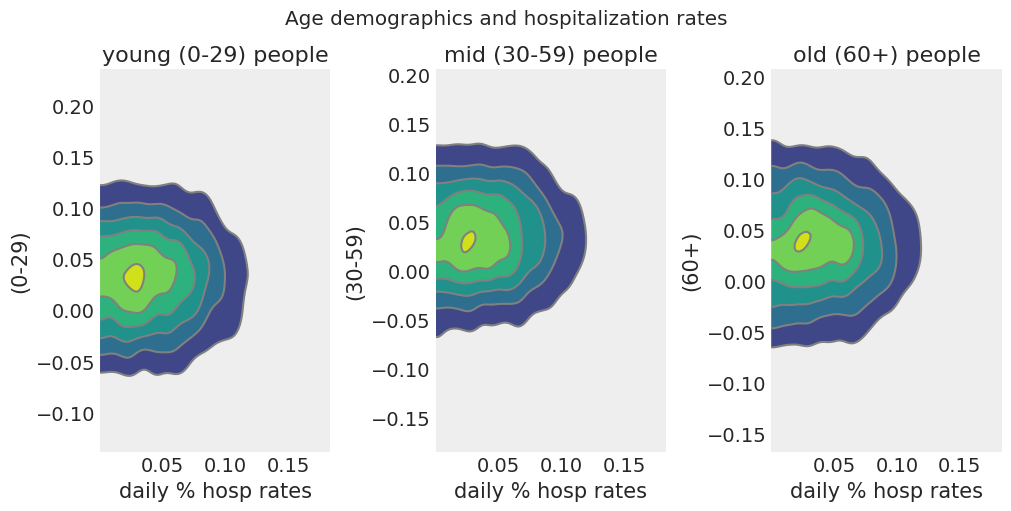

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Age demographics and hospitalization rates')

az.plot_kde(hospital_theta, theta1, ax=ax1)
az.plot_kde(hospital_theta, theta2, ax=ax2)
az.plot_kde(hospital_theta, theta3, ax=ax3)

# labels
ax1.set_title('young (0-29) people')
ax2.set_title('mid (30-59) people')
ax3.set_title('old (60+) people')

# set x labels
ax1.set_xlabel("daily % hosp rates")
ax2.set_xlabel("daily % hosp rates")
ax3.set_xlabel("daily % hosp rates")


# set y labels
ax1.set_ylabel("(0-29)")
ax2.set_ylabel("(30-59)")
ax3.set_ylabel("(60+)")

#plt.legend(loc='upper right');
plt.show()

## 2.2 Gaussian Mixture Model for Age (5/1/21 Incomplete)

In [ ]:
# prepare data for Gaussian Mixture Model
deaths = death_df['death cum count percent change'].tolist()

# The variables we want to predict
daily_death_percent = [0,0,0] + deaths # to line up the arrays because deaths is only 438 rows.
daily_hosp_percent = hosp_df['hosp_yn cum count percent change'].tolist()

# the variables we want to input
X = stan_model_data['young_daily_covid_percent'].tolist()
Y = stan_model_data['mid_daily_covid_percent'].tolist()
Z = stan_model_data['old_daily_covid_percent'].tolist()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

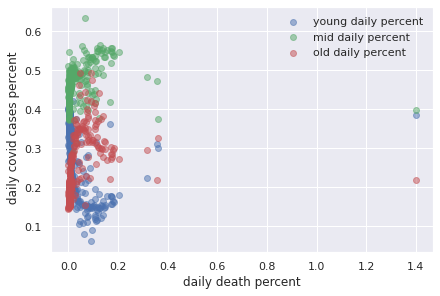

In [ ]:
# data we are plotting for b and c numpy arrays and GMM
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.scatter(daily_death_percent, X, c='b', alpha=0.5, label='young daily percent')
ax2.scatter(daily_death_percent, Y, c='g', alpha=0.5, label='mid daily percent')
ax2.scatter(daily_death_percent, Z, c='r', alpha=0.5, label='old daily percent')


plt.xlabel("daily death percent")
plt.ylabel(" daily covid cases percent")

plt.legend(loc='upper right');
plt.show()

In [ ]:
b = np.array((X, Y, Z), dtype=float)
b = np.nan_to_num(b)
b

array([[0.26819923, 0.30875576, 0.32758621, ..., 0.40024285, 0.40366227,
        0.36478579],
       [0.47509579, 0.51152074, 0.43103448, ..., 0.45488351, 0.44681105,
        0.44855626],
       [0.25670498, 0.1797235 , 0.24137931, ..., 0.14487364, 0.14952668,
        0.18665795]])

In [ ]:
b = np.transpose(b)
b

array([[0.26819923, 0.47509579, 0.25670498],
       [0.30875576, 0.51152074, 0.1797235 ],
       [0.32758621, 0.43103448, 0.24137931],
       ...,
       [0.40024285, 0.45488351, 0.14487364],
       [0.40366227, 0.44681105, 0.14952668],
       [0.36478579, 0.44855626, 0.18665795]])

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(b)
labels = gmm.predict(b)

In [ ]:
labels.shape

(441,)

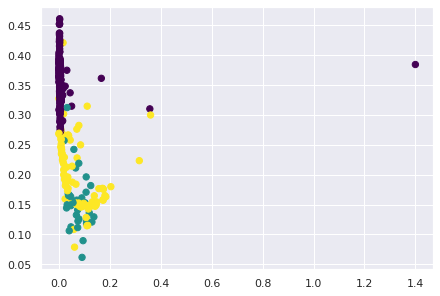

In [ ]:
# plt.scatter(c[:, 0], c[:, 1], c=labels, s=40, cmap='viridis');
plt.scatter(daily_death_percent, b[:, 0], c=labels, s=40, cmap='viridis');

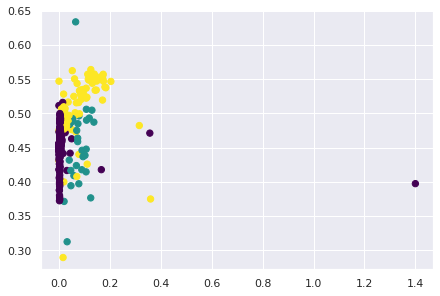

In [ ]:
plt.scatter(daily_death_percent, b[:, 1], c=labels, s=40, cmap='viridis');

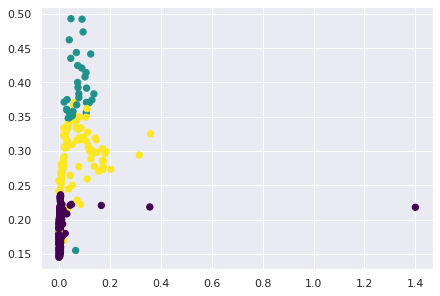

In [ ]:
plt.scatter(daily_death_percent, b[:, 2], c=labels, s=40, cmap='viridis');

In [ ]:
# 4/27/21 do linear regression with cmdstanpy?
# https://mc-stan.org/docs/2_26/stan-users-guide/linear-regression.html

# 2.3 Stan model for ethnicity

In [ ]:
# recall the important names for ethnicity data
print(ethnicity_list_largest)
len(ethnicity_data_list)

['Asian, Non-Hispanic', 'Black, Non-Hispanic', 'Hispanic/Latino', 'White, Non-Hispanic']


4

In [ ]:
# turn each list element into an array. 
ethnicity_data_list_arr = [np.asarray(x) for x in ethnicity_data_list]

# turn all inf/-inf values in array to 0
ethnicity_data_list_arr = [np.nan_to_num(x, neginf=0, posinf=0) for x in ethnicity_data_list]
# ethnicity_data_list_arr

In [ ]:
# prepare data to put into dictionary. Data needs to be in dictionary format to use in Stan
index_count = len(ethnicity_data_list_arr)

keys = ['N', 'y1', 'y2', 'y3', 'y4']
ethnicity_data_dict = dict(zip(keys,[441, ethnicity_data_list_arr[0], ethnicity_data_list_arr[1], ethnicity_data_list_arr[2], ethnicity_data_list_arr[3]])) # is it supposed to be 441 or 4? 
ethnicity_data_dict.keys()

dict_keys(['N', 'y1', 'y2', 'y3', 'y4'])

In [ ]:
#create basic STAN model with covid case percents based on ethnicities

ethnicity_model = """
data { 
  int<lower=0> N; // number of daily counts
  vector[N] y1; //  percentage of ethnicity 1
  vector[N] y2; //  percentage of ethnicity 2
  vector[N] y3; //  percentage of ethnicity 3
  vector[N] y4; //  percentage of ethnicity 4
} 

parameters {
  real theta1;
  real theta2;
  real theta3;
  real theta4;
} 

model {
  theta1 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y1 ~ normal(theta1, 1);

  theta2 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y2 ~ normal(theta2, 1);

  theta3 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y3 ~ normal(theta3, 1);

  theta4 ~ normal(0, 1); // parameter theta is assumed to come from normal distribution
  y4 ~ normal(theta4, 1);

}
"""

with open("ethnicity_model.stan", "w") as f:
    f.write(ethnicity_model)

sm_ethnicity = cmdstanpy.CmdStanModel(stan_file="ethnicity_model.stan")
samples_ethnicity = sm_ethnicity.sample(data=ethnicity_data_dict, output_dir="./")

INFO:cmdstanpy:compiling stan program, exe file: /content/ethnicity_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/ethnicity_model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [ ]:
# where theta1 to theta4 corresponds to ['Asian, Non-Hispanic', 'Black, Non-Hispanic', 'Hispanic/Latino', 'White, Non-Hispanic']
samples_ethnicity.summary().round(decimals=4)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-99.0000,0.0290,1.400,-100.000,-98.0000,-97.000,2300.0,16000.0,1.0
theta1,0.0320,0.0008,0.047,-0.045,0.0330,0.110,3600.0,24000.0,1.0
theta2,0.0350,0.0007,0.047,-0.042,0.0330,0.110,4900.0,32000.0,1.0
theta3,0.0350,0.0007,0.048,-0.045,0.0350,0.110,4600.0,30000.0,1.0
theta4,0.0066,0.0006,0.047,-0.071,0.0058,0.085,5400.0,36000.0,1.0


In [ ]:
inf_data_ethnicity = az.convert_to_inference_data(samples_ethnicity) #samples is the "fit" data

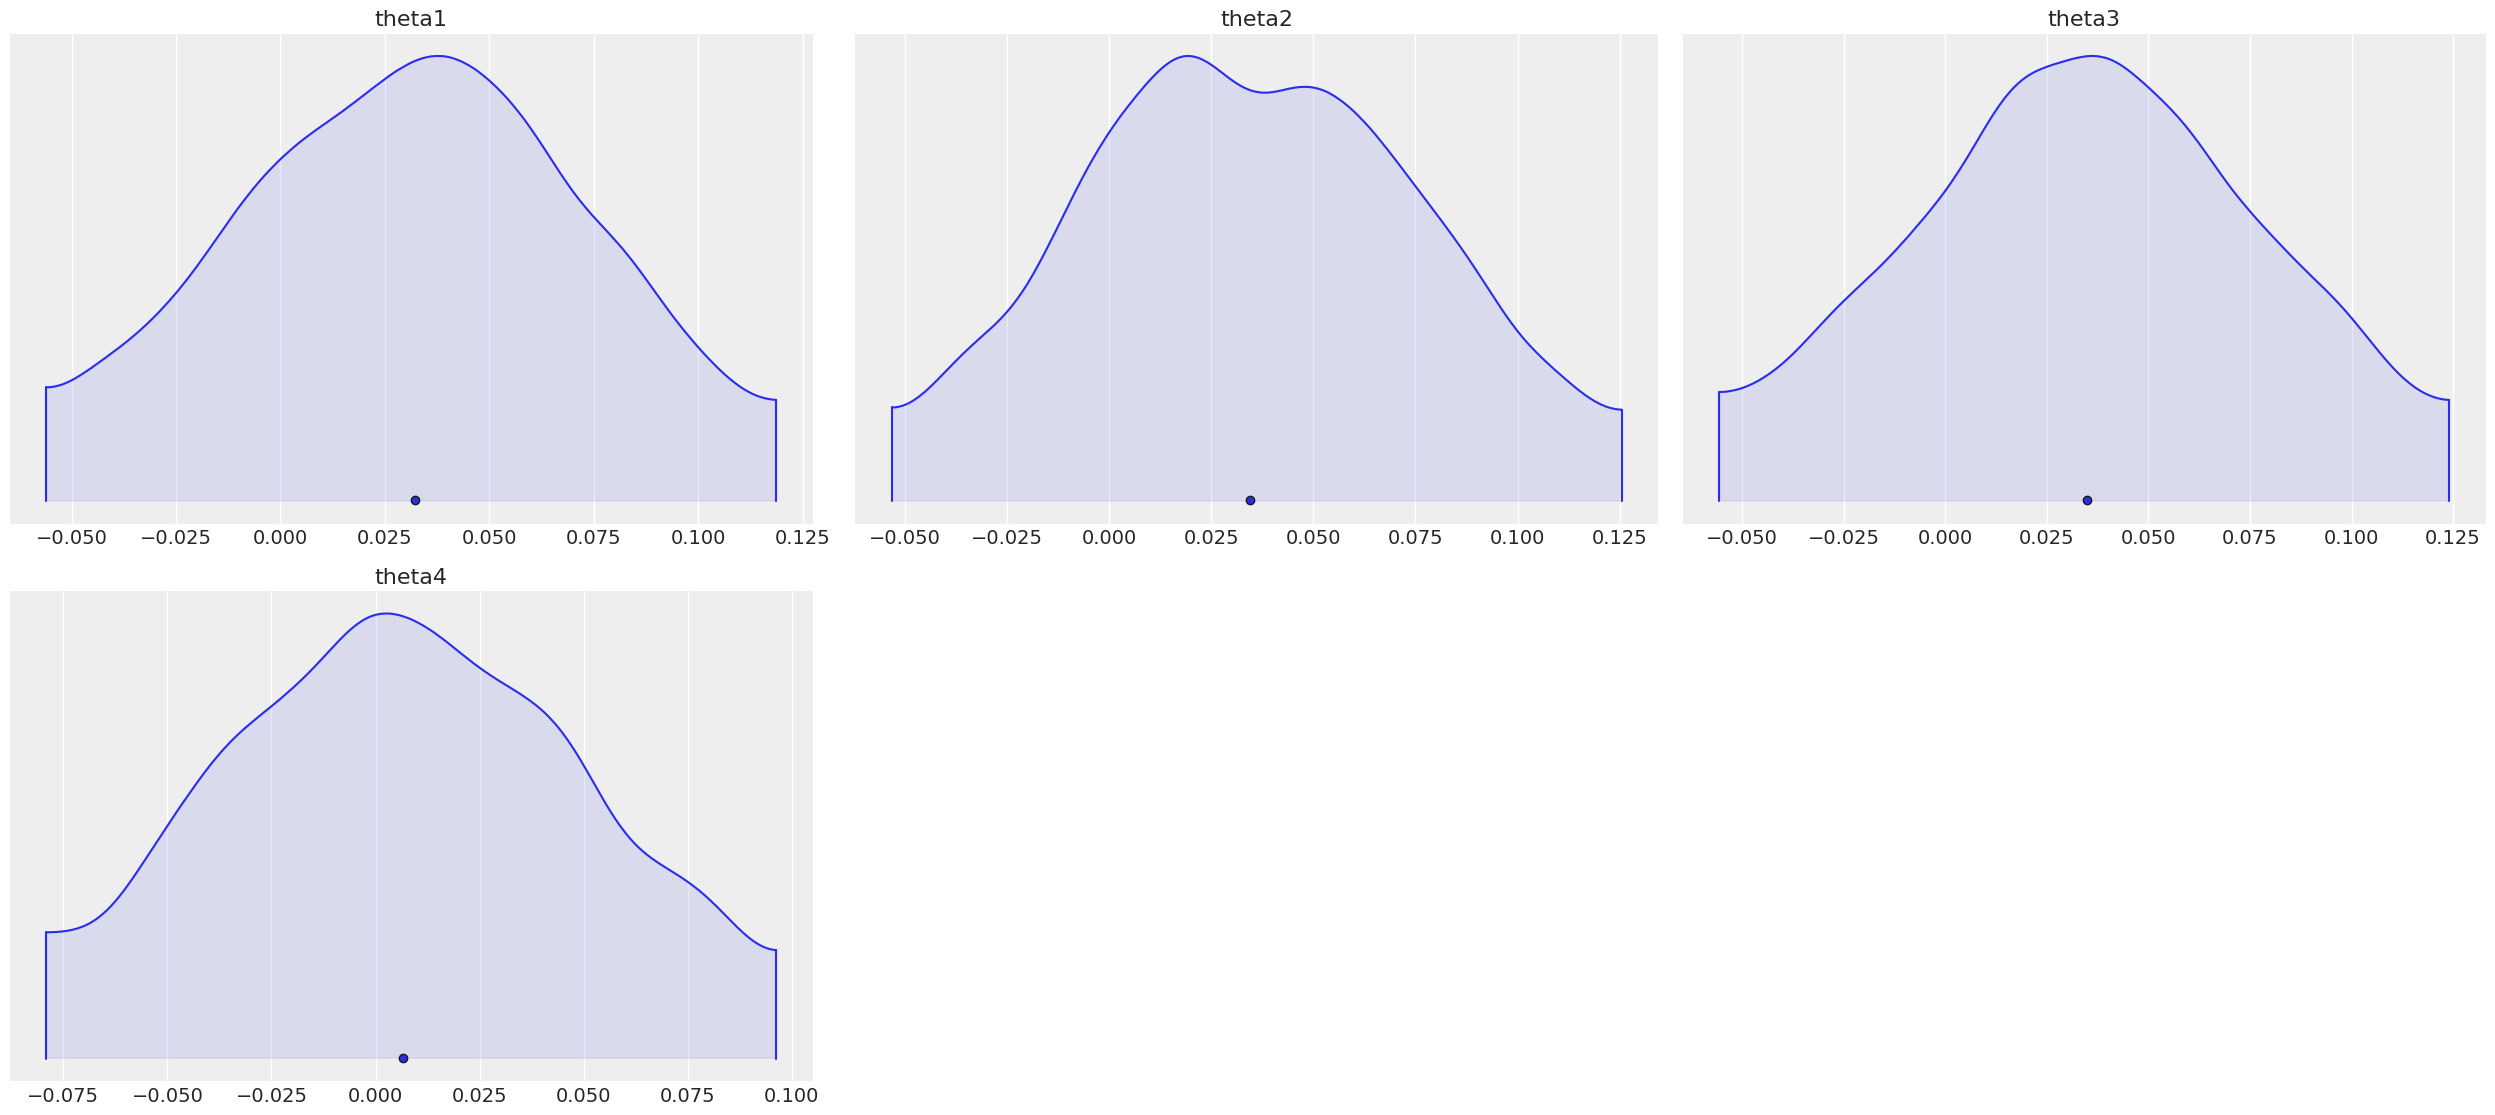

In [ ]:
az.style.use("arviz-darkgrid")


az.plot_density(
    [inf_data_ethnicity],
    var_names=["theta1", "theta2", "theta3", "theta4"],
    shade=0.1,
)
plt.show()

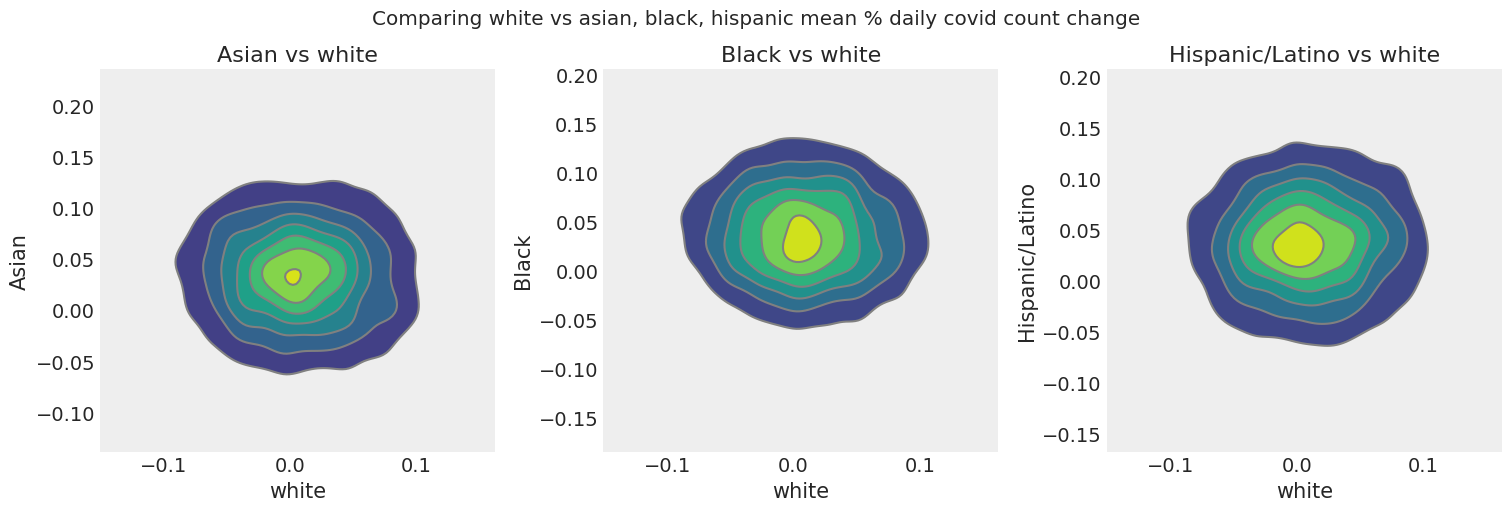

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Comparing white vs asian, black, hispanic mean % daily covid count change')

theta1 = inf_data_ethnicity.posterior.theta1
theta2 = inf_data_ethnicity.posterior.theta2
theta3 = inf_data_ethnicity.posterior.theta3
theta4 = inf_data_ethnicity.posterior.theta4

az.plot_kde(theta4, theta1, ax=ax1)
az.plot_kde(theta4, theta2, ax=ax2)
az.plot_kde(theta4, theta3, ax=ax3)

# labels
ax1.set_title('Asian vs white')
ax2.set_title('Black vs white')
ax3.set_title('Hispanic/Latino vs white')

# set x axis for subplots
ax1.set_xlabel("white")
ax2.set_xlabel("white")
ax3.set_xlabel("white")
ax4.set_xlabel("white")

# set y axis for subplots
ax1.set_ylabel("Asian")
ax2.set_ylabel('Black')
ax3.set_ylabel("Hispanic/Latino")

#plt.legend(loc='upper right');
plt.show()